<a href="https://colab.research.google.com/github/Akashdesarda/toxicity-analyzer/blob/master/transformer_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
pip install transformers clean-text

In [0]:
from transformers import XLNetConfig, XLNetTokenizer, TFXLNetModel, RobertaConfig, RobertaTokenizer, TFRobertaModel
import tensorflow as tf
import pandas as pd
import numpy as np
from cleantext import clean
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


In [0]:
train_data = pd.read_csv('/content/train.csv')
# test_data = pd.read_csv('/content/test.csv')

label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [0]:
#Cleaning Text
def cleaning(text):
    return clean(text, no_line_breaks=True, no_urls=True, no_punct=True)

#tokenizing input text
def tokenize(sentences, tokenizer):
    input_ids, input_masks, input_segments = [],[],[]
    for sentence in tqdm(sentences):
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=128, pad_to_max_length=True, 
                                             return_attention_mask=True, return_token_type_ids=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])        
        
    return [np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32')]

In [0]:
tqdm.pandas()
train_data['comment_text'] = train_data['comment_text'].progress_apply(cleaning)

100%|██████████| 159571/159571 [00:55<00:00, 2869.47it/s]


In [0]:
distil_bert = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(distil_bert, do_lower_case=True, add_special_tokens=True,
                                                max_length=128, pad_to_max_length=True)

config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
config.output_hidden_states = False
transformer_model = TFDistilBertModel.from_pretrained(distil_bert, config = config)

ValueError: ignored

In [0]:
def create_model_dense():
    input_ids_in = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
    input_masks_in = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32') 
    
    embedding_layer = transformer_model(input_ids_in, attention_mask=input_masks_in)[0]
    X = tf.keras.layers.GlobalAveragePooling1D()(embedding_layer)
    X = tf.keras.layers.Dropout(0.2)(X)
    X = tf.keras.layers.Dense(6, activation='sigmoid')(X)
    model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)

    for layer in model.layers[:-1]:
      layer.trainable = False
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4, epsilon=1e-08, clipnorm=1.0)
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

In [0]:
features = tokenize(train_data['comment_text'], tokenizer)
labels = train_data[label_cols].values

100%|██████████| 159571/159571 [03:29<00:00, 763.19it/s]


In [0]:
xtrain_id, xtest_id, xtrain_mask, xtest_mask, ytrain, ytest = train_test_split(features[0], features[1], labels, test_size=0.3, random_state=42)

In [0]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=3, verbose=1, restore_best_weights=True)
lr_on_pla = tf.keras.callbacks.ReduceLROnPlateau(patience=2)

In [0]:
model = create_model_dense()
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_2 (TFDisti ((None, 128, 768),)  66362880    input_token[0][0]                
__________________________________________________________________________________________________
global_average_pooling1d_1 (Glo (None, 768)          0           tf_distil_bert_model_2[2][0]     
____________________________________________________________________________________________

In [0]:
hist = model.fit([xtrain_id,xtrain_mask],
                ytrain,
                validation_data = ([xtest_id, xtest_mask], ytest),
                epochs=5,
                batch_size=64,
                callbacks=[early_stop, lr_on_pla])

Epoch 1/5
1746/1746 [==============================] - 2784s 2s/step - loss: 0.3938 - accuracy: 0.5952 - val_loss: 0.3960 - val_accuracy: 0.9940 - lr: 3.0000e-04
Epoch 2/5
1746/1746 [==============================] - 2784s 2s/step - loss: 0.3932 - accuracy: 0.5242 - val_loss: 0.3960 - val_accuracy: 0.9940 - lr: 3.0000e-04
Epoch 3/5
1746/1746 [==============================] - 2794s 2s/step - loss: 0.3931 - accuracy: 0.4825 - val_loss: 0.3960 - val_accuracy: 0.9940 - lr: 3.0000e-04
Epoch 4/5
1746/1746 [==============================] - 2805s 2s/step - loss: 0.3932 - accuracy: 0.4607 - val_loss: 0.3960 - val_accuracy: 0.9940 - lr: 3.0000e-05
Epoch 00004: early stopping


In [0]:
p = model.predict([features[0][10],features[1][10]])

In [0]:
sample = tokenize(train_data['comment_text'][50:60], tokenizer)

100%|██████████| 10/10 [00:00<00:00, 378.94it/s]


In [0]:
sample = tokenizer.encode_plus(train_data['comment_text'][:10], add_special_tokens=True, max_length=128, pad_to_max_length=True, 
                                             return_attention_mask=True, return_token_type_ids=True)

ValueError: ignored

In [0]:
sample_id,sample_mask = np.asarray(sample['input_ids']).reshape(1,-1), np.asarray(sample['attention_mask']).reshape(1,-1)

In [0]:
sample_id.shape

(1, 128)

In [0]:
p = model.predict([sample_id, sample_mask])

In [0]:
p.shape

(1, 6)

In [0]:
p

array([[4.3992776e-07, 3.0000902e-07, 3.0548125e-07, 2.0480077e-07,
        2.9252541e-07, 2.8055911e-07]], dtype=float32)

In [0]:
sample_test = test_data.head()

In [0]:
sample_test['comment_text'] = sample_test['comment_text'].apply(cleaning)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
sample_test

,id,comment_text
0,00001cee341fdb12,yo bitch ja rule is more succesful then you'll...
1,0000247867823ef7,"== from rfc == the title is fine as it is, imo."
2,00013b17ad220c46,""" == sources == * zawe ashton on lapland — / """
3,00017563c3f7919a,":if you have a look back at the source, the in..."
4,00017695ad8997eb,i don't anonymously edit articles at all.


In [0]:
sample_test_tok = tokenize(sample_test['comment_text'], tokenizer)

100%|██████████| 5/5 [00:00<00:00, 726.49it/s]


In [0]:
sample_test_tok[0].shape

(5, 128)

In [0]:
sample_pred = model.predict(sample_test_tok)

In [0]:
sample_pred.shape

(5, 6)

In [0]:
pd.DataFrame(sample_pred)

,0,1,2,3,4,5
0,4.399278e-07,3.000090e-07,3.054816e-07,2.048000e-07,2.925221e-07,2.805575e-07
1,4.399273e-07,3.000093e-07,3.054813e-07,2.047996e-07,2.925227e-07,2.805575e-07
2,4.399278e-07,3.000093e-07,3.054813e-07,2.048000e-07,2.925223e-07,2.805572e-07
3,4.399281e-07,3.000090e-07,3.054816e-07,2.047996e-07,2.925227e-07,2.805572e-07
4,4.399278e-07,3.000093e-07,3.054816e-07,2.047994e-07,2.925227e-07,2.805570e-07


In [0]:
model.layers

In [0]:
model.layers[:-1]

In [0]:
model2 = create_model_dense()
model2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB ((None, 128, 768),)  66362880    input_token[0][0]                
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 128, 100)     327600      tf_distil_bert_model[0][0]       
______________________________________________________________________________________________

In [0]:
hist2 = model2.fit([xtrain_id,xtrain_mask],
                ytrain,
                validation_data = ([xtest_id, xtest_mask], ytest),
                epochs=5,
                batch_size=64,
                callbacks=[early_stop, lr_on_pla])

Epoch 1/5
1746/1746 [==============================] - 1185s 679ms/step - loss: 0.3930 - accuracy: 0.3064 - val_loss: 0.3960 - val_accuracy: 0.0023 - lr: 3.0000e-04
Epoch 2/5
  26/1746 [..............................] - ETA: 13:24 - loss: 0.4199 - accuracy: 0.3053

In [0]:
pipeline = pipeline('')

In [0]:
def create_model_dense():
    input_ids_in = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
    input_masks_in = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32') 
    
    embedding_layer = transformer_model(input_ids_in, attention_mask=input_masks_in)[0]
    # cls_token = embedding_layer[:,0,:]
    X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(embedding_layer)
    X = tf.keras.layers.GlobalMaxPool1D()(X)
    # X = tf.keras.layers.BatchNormalization()(cls_token)
    X = tf.keras.layers.Dense(50, activation='relu')(X)
    X = tf.keras.layers.Dropout(0.2)(X)
    X = tf.keras.layers.Dense(6, activation='sigmoid')(X)
    model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)

    for layer in model.layers[:3]:
      layer.trainable = False
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4, epsilon=1e-08, clipnorm=1.0)
    # loss = tf.keras.losses.binary_crossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [0]:
model = create_model_dense()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB ((None, 128, 768),)  66362880    input_token[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 128, 100)     327600      tf_distil_bert_model[1][0]       
____________________________________________________________________________________________

In [0]:
model.layers[:3]

In [0]:
features[0].shape

(159571, 128)

In [0]:
hist = model.fit(features, labels, epochs=5, batch_size=64, validation_split=0.3, 
                 callbacks=[early_stop, lr_on_pla])

Epoch 1/5
1746/1746 [==============================] - 1776s 1s/step - loss: 0.0765 - accuracy: 0.7950 - val_loss: 0.0530 - val_accuracy: 0.9940 - lr: 3.0000e-04
Epoch 2/5
1746/1746 [==============================] - 1804s 1s/step - loss: 0.0537 - accuracy: 0.9357 - val_loss: 0.0485 - val_accuracy: 0.9940 - lr: 3.0000e-04
Epoch 3/5
1746/1746 [==============================] - 1796s 1s/step - loss: 0.0493 - accuracy: 0.9636 - val_loss: 0.0459 - val_accuracy: 0.9940 - lr: 3.0000e-04
Epoch 4/5
1746/1746 [==============================] - 1759s 1s/step - loss: 0.0466 - accuracy: 0.9756 - val_loss: 0.0443 - val_accuracy: 0.9940 - lr: 3.0000e-04
Epoch 5/5
1746/1746 [==============================] - 1763s 1s/step - loss: 0.0448 - accuracy: 0.9800 - val_loss: 0.0446 - val_accuracy: 0.9938 - lr: 3.0000e-04


In [0]:
pred = model.predict(sample)

In [0]:
pred

array([[7.53691769e-04, 3.12746693e-07, 2.13015053e-04, 5.71938244e-07,
        6.08515038e-05, 1.71638976e-06],
       [9.95556653e-01, 3.27569634e-01, 9.78421330e-01, 3.74138132e-02,
        7.00525999e-01, 2.54591126e-02],
       [1.63472351e-02, 1.13446049e-05, 8.42143025e-04, 1.07265558e-04,
        1.56133238e-03, 3.64549895e-04],
       [1.05893821e-03, 3.02718348e-07, 1.57292961e-04, 1.08350559e-06,
        8.27284530e-05, 2.99286216e-06],
       [9.93183628e-03, 1.31834877e-05, 1.00125675e-03, 1.13532886e-04,
        1.43538043e-03, 8.02607174e-05],
       [9.98250782e-01, 4.94070411e-01, 9.62710321e-01, 4.85801578e-01,
        8.94553661e-01, 1.80445150e-01],
       [9.81421709e-01, 1.40982181e-01, 9.29603100e-01, 1.03032719e-02,
        7.29796827e-01, 7.51813576e-02],
       [2.31255617e-04, 2.81635089e-08, 2.47061253e-05, 1.95208983e-07,
        1.17076315e-05, 5.02914645e-07],
       [9.74545181e-01, 1.79375127e-01, 9.04975295e-01, 1.73110031e-02,
        7.37176895e-01, 

In [0]:
model.save('tra_lstm.h5')

NotImplementedError: ignored

In [0]:
def create_model_dense():
    input_ids_in = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
    input_masks_in = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32') 
    
    embedding_layer = transformer_model(input_ids_in, attention_mask=input_masks_in)[0]
    cls_token = embedding_layer[:,0,:]
    # X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(embedding_layer)
    # X = tf.keras.layers.GlobalMaxPool1D()(X)
    X = tf.keras.layers.BatchNormalization()(cls_token)
    X = tf.keras.layers.Dense(192, activation='relu')(X)
    X = tf.keras.layers.Dropout(0.2)(X)
    X = tf.keras.layers.Dense(6, activation='softmax')(X)
    model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)

    for layer in model.layers[:3]:
      layer.trainable = False
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4, epsilon=1e-08, clipnorm=1.0)
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

In [0]:
model = create_model_dense()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB ((None, 128, 768),)  66362880    input_token[0][0]                
__________________________________________________________________________________________________
tf_op_layer_strided_slice_1 (Te [(None, 768)]        0           tf_distil_bert_model[2][0]       
____________________________________________________________________________________________

In [0]:
hist = model.fit(features, labels, epochs=5, batch_size=64, validation_split=0.3, 
                 callbacks=[early_stop, lr_on_pla])

Epoch 1/5
1746/1746 [==============================] - 846s 485ms/step - loss: 0.3608 - accuracy: 0.4139 - val_loss: 0.3598 - val_accuracy: 0.3803 - lr: 3.0000e-04
Epoch 2/5
1746/1746 [==============================] - 846s 484ms/step - loss: 0.3600 - accuracy: 0.4699 - val_loss: 0.3601 - val_accuracy: 0.4971 - lr: 3.0000e-04
Epoch 3/5
1746/1746 [==============================] - 845s 484ms/step - loss: 0.3598 - accuracy: 0.5428 - val_loss: 0.3600 - val_accuracy: 0.5527 - lr: 3.0000e-04
Epoch 4/5
1746/1746 [==============================] - 846s 484ms/step - loss: 0.3592 - accuracy: 0.5705 - val_loss: 0.3603 - val_accuracy: 0.5697 - lr: 3.0000e-05
Epoch 00004: early stopping


In [0]:
!zip -r ./tra_lstm.zip ./tra_lstm/

  adding: tra_lstm/ (stored 0%)
  adding: tra_lstm/saved_model.pb (deflated 92%)
  adding: tra_lstm/assets/ (stored 0%)
  adding: tra_lstm/variables/ (stored 0%)
  adding: tra_lstm/variables/variables.data-00000-of-00002 (deflated 10%)
  adding: tra_lstm/variables/variables.data-00001-of-00002 (deflated 8%)
  adding: tra_lstm/variables/variables.index (deflated 74%)


In [0]:
from google.colab import files
files.download('./tra_lstm.zip')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 43204, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

In [0]:
m = tf.keras.models.load_model('./tra_lstm/')

ValueError: ignored

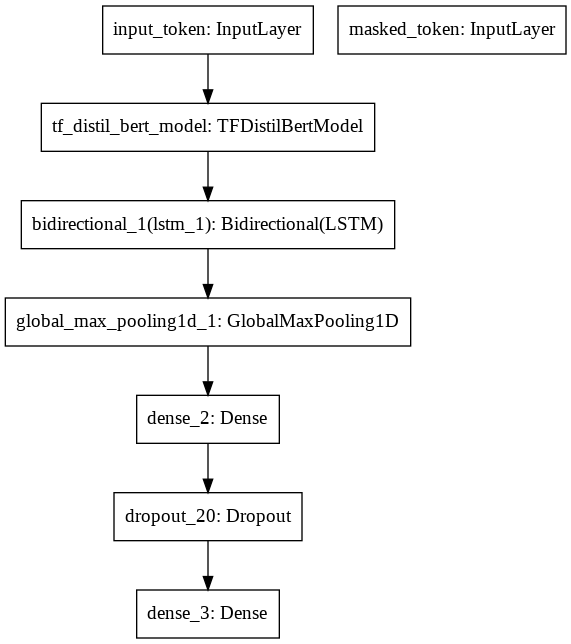

In [0]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

In [0]:
test_data = pd.read_csv('test.csv')

In [0]:
test_data['comment_text'] = test_data['comment_text'].progress_apply(cleaning)

100%|██████████| 153164/153164 [00:50<00:00, 3044.09it/s]


In [0]:
submission = tokenize(test_data['comment_text'], tokenizer)

100%|██████████| 153164/153164 [03:04<00:00, 828.19it/s]


In [0]:
type(submission)

list

In [0]:
sub_pre = model.predict(submission)

In [0]:
sub_pre[0]

array([0.9963875 , 0.46869907, 0.96749395, 0.17178415, 0.9264728 ,
       0.5689469 ], dtype=float32)

In [0]:
final_submission = pd.DataFrame(columns=train_data.columns)

In [0]:
final_submission = pd.DataFrame(sub_pre)

In [0]:
final_submission.columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [0]:
final_submission.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0.996387,4.686991e-01,0.967494,1.717841e-01,0.926473,5.689469e-01
1,0.008181,1.001349e-05,0.001462,2.588653e-05,0.000662,4.822923e-05
2,0.007346,2.684145e-05,0.001496,7.964475e-05,0.000557,1.879070e-04
3,0.000262,6.307355e-08,0.000028,5.318001e-07,0.000020,3.820086e-07
4,0.003519,1.567307e-06,0.000255,1.310494e-05,0.000161,2.030588e-05


In [0]:
final_submission['id'] =  test_data['id']

In [0]:
final_submission.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,id
0,0.996387,4.686991e-01,0.967494,1.717841e-01,0.926473,5.689469e-01,00001cee341fdb12
1,0.008181,1.001349e-05,0.001462,2.588653e-05,0.000662,4.822923e-05,0000247867823ef7
2,0.007346,2.684145e-05,0.001496,7.964475e-05,0.000557,1.879070e-04,00013b17ad220c46
3,0.000262,6.307355e-08,0.000028,5.318001e-07,0.000020,3.820086e-07,00017563c3f7919a
4,0.003519,1.567307e-06,0.000255,1.310494e-05,0.000161,2.030588e-05,00017695ad8997eb


In [0]:
fs = final_submission[['id', 'toxic', 'severe_toxic', 'obscene',	'threat', 'insult', 'identity_hate']]

In [0]:
fs.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.996387,4.686991e-01,0.967494,1.717841e-01,0.926473,5.689469e-01
1,0000247867823ef7,0.008181,1.001349e-05,0.001462,2.588653e-05,0.000662,4.822923e-05
2,00013b17ad220c46,0.007346,2.684145e-05,0.001496,7.964475e-05,0.000557,1.879070e-04
3,00017563c3f7919a,0.000262,6.307355e-08,0.000028,5.318001e-07,0.000020,3.820086e-07
4,00017695ad8997eb,0.003519,1.567307e-06,0.000255,1.310494e-05,0.000161,2.030588e-05


In [0]:
fs.to_csv('submission.csv', index=None)

In [0]:
df = pd.read_csv('submission.csv')
df.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.996387,4.686991e-01,0.967494,1.717841e-01,0.926473,5.689469e-01
1,0000247867823ef7,0.008181,1.001349e-05,0.001462,2.588653e-05,0.000662,4.822923e-05
2,00013b17ad220c46,0.007346,2.684145e-05,0.001496,7.964475e-05,0.000557,1.879071e-04
3,00017563c3f7919a,0.000262,6.307355e-08,0.000028,5.318001e-07,0.000020,3.820085e-07
4,00017695ad8997eb,0.003519,1.567307e-06,0.000255,1.310494e-05,0.000161,2.030588e-05


In [0]:
model.save_weights('tra_lstm_weights.h5')

In [0]:
distil_bert = 'distilbert-base-uncased'

config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
config.output_hidden_states = False
transformer_model = TFDistilBertModel.from_pretrained(distil_bert, config = config)

input_ids_in = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32') 

embedding_layer = transformer_model(input_ids_in, attention_mask=input_masks_in)[0]
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(embedding_layer)
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(50, activation='relu')(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(6, activation='sigmoid')(X)
model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)

for layer in model.layers[:3]:
  layer.trainable = False

In [0]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_2 (TFDisti ((None, 128, 768),)  66362880    input_token[0][0]                
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 128, 100)     327600      tf_distil_bert_model_2[0][0]     
____________________________________________________________________________________________

In [0]:
transformer_model.summary()

Model: "tf_distil_bert_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain ((None, 128, 768),)       66362880  
Total params: 66,362,880
Trainable params: 0
Non-trainable params: 66,362,880
_________________________________________________________________


In [0]:
!ls /content -a

.	 .ipynb_checkpoints  sample_data     train.csv		  tra_lstm.zip
..	 m1.png		     submission.csv  tra_lstm
.config  model.png	     test.csv	     tra_lstm_weights.h5


Diffrent Model

In [0]:
distil_bert = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(distil_bert, do_lower_case=True, add_special_tokens=True,
                                                max_length=128, pad_to_max_length=True)

config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
config.output_hidden_states = False
transformer_model = TFDistilBertModel.from_pretrained(distil_bert, config = config)